Import libraries

In [ ]:
!pip install -U torchtext==0.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 974.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


Get data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data_folder = '/content/gdrive/MyDrive/Third Year/Summer 2023/Summer Research/Session 3/Grouped Segments'

In [ ]:
import pandas as pd

class_names = ['Elbow', 'Forearm', 'ShoulderAB', 'ShoulderEF',
               'ShoulderHor', 'ShoulderLat', 'ShoulderCircle', 'Wrist']

data_array = []
label_array = []
tensor_array = []

for i in range(8):
  files = os.listdir(data_folder + '/' + class_names[i])

  for file in files:
    data = pd.read_csv(data_folder + '/' + class_names[i] + '/' + file)
    data_array.append(data.values[:, :18])
    tensor_array.append(torch.tensor(data.values[:, :18], dtype=torch.float32).unsqueeze(0))
    label_array.append(i)


'''for file in files0:
  data = pd.read_csv(data_folder + '/movement 0/' + file)
  data_array.append(data.values[:, :18])
  tensor_array.append(torch.tensor(data.values[:, :18], dtype=torch.float32).unsqueeze(0))
  label_array.append(1)

for file in files1:
  data = pd.read_csv(data_folder + '/movement 1/' + file)
  data_array.append(data.values[:, :18])
  tensor_array.append(torch.tensor(data.values[:, :18], dtype=torch.float32).unsqueeze(0))
  label_array.append(0)

for file in files2:
  data = pd.read_csv(data_folder + '/movement 2/' + file)
  data_array.append(data.values[:, :18])
  tensor_array.append(torch.tensor(data.values[:, :18], dtype=torch.float32).unsqueeze(0))
  label_array.append(0)'''

print(data_array[0], label_array)
print(len(label_array))


[[ 8.40000000e-01 -3.50000000e-01  4.00000000e-01 -7.96104006e-02
  -1.61461260e-01 -5.63350952e-02  9.70000000e-01 -4.00000000e-02
   1.10000000e-01 -1.81918449e-01 -2.67663744e-01  5.19454380e-02
   9.70000000e-01 -8.00000000e-02  4.00000000e-02 -5.14982112e-01
  -1.89525994e-01  1.08015971e-01]
 [ 8.40000000e-01 -3.50000000e-01  4.00000000e-01 -9.20214081e-02
  -1.75314477e-01 -5.46683025e-02  9.70000000e-01 -3.88004408e-02
   1.11199559e-01  7.08564236e-01 -2.20666438e-01 -6.69760914e-01
   9.70000000e-01 -8.00000000e-02  4.00000000e-02 -4.96322707e-01
  -1.98963328e-01  6.54675091e-02]
 [ 8.40000000e-01 -3.50000000e-01  4.00000000e-01 -7.68931446e-02
  -1.39662662e-01 -3.10895118e-02  9.67783083e-01 -2.11008716e-02
   1.21139920e-01  6.98444964e+00  3.41630540e+00  2.02878025e+00
   9.70000000e-01 -8.00000000e-02  4.00000000e-02 -4.63093744e-01
  -1.91916972e-01  5.35230850e-02]
 [ 8.40000000e-01 -3.50000000e-01  4.00000000e-01 -9.04427603e-02
  -1.82683705e-01 -3.50129476e-02  9.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class NumpyArrayDataset(Dataset):
    def __init__(self, numpy_arrays, labels):
        self.data = numpy_arrays
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
def pad_sequences(sequences, max_length):
    padded_sequences = np.zeros((len(sequences), max_length, sequences[0].shape[1]), dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :seq.shape[0], :] = seq
    return padded_sequences


def create_data_loader(numpy_arrays, labels, batch_size):
    # Find the maximum length in the dataset
    max_length = max(arr.shape[0] for arr in numpy_arrays)

    # Pad the sequences to the maximum length
    padded_sequences = pad_sequences(numpy_arrays, max_length)

    # Convert the numpy arrays and labels to PyTorch tensors
    tensor_data = torch.tensor(padded_sequences)
    tensor_labels = torch.tensor(labels)

    # Create the custom dataset and DataLoader
    dataset = NumpyArrayDataset(tensor_data, tensor_labels)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_loader


In [ ]:
model = LSTM_Classifier(6, 100, 1, 2)

# Assuming you have already instantiated your LSTM model

# Set hyperparameters
batch_size = 1
num_epochs = 10
learning_rate = 0.001

# Create the DataLoader
data_loader = create_data_loader(data_array, label_array, 1)

# Print some samples from the data loader
for batch_idx, (data, labels) in enumerate(data_loader):
    print(f"Batch {batch_idx}:")
    print("Data:")
    print(data)
    print("Labels:")
    print(labels)
    if batch_idx >= 2:  # Print the first three batches (you can adjust this value)
        break

NameError: ignored

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Your LSTM_Classifier and other code...

# Assuming you have your_numpy_arrays and your_labels as input data
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(data_array, label_array, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Create DataLoaders for train, validation, and test sets
train_loader = create_data_loader(X_train, y_train, 1)
val_loader = create_data_loader(X_val, y_val, 1)
test_loader = create_data_loader(X_test, y_test, 1)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

# Training loop using train_loader, validation using val_loader, and testing using test_loader...


108
14
14


Model

In [ ]:
'''class LSTM_Classifier(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(LSTM_Classifier, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    #set initial hidden states
    h0 = torch.zeros(1, x.size(0), self.hidden_size) #hidden state
    c0 = torch.zeros(1, x.size(0), self.hidden_size) #cell state

    #forward propagate LSTM
    out, __ = self.lstm(x, (h0, c0)) #pass both memories
    #pass output to classifier
    return self.fc(out[:,-1,:])'''

import torch.nn as nn

class LSTM_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_Classifier, self).__init__()
        self.name = "LSTM_Classifier"
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, lengths):
        # Sort the input sequences by length in descending order
        sorted_lengths, sort_idx = torch.sort(lengths, descending=True)
        x_sorted = x[sort_idx]

        # Pack the padded sequences
        packed_data = nn.utils.rnn.pack_padded_sequence(x_sorted, sorted_lengths, batch_first=True)

        # Forward propagate LSTM
        packed_output, _ = self.lstm(packed_data)

        # Unpack the packed sequences
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Reorder the output back to the original order
        _, unsort_idx = torch.sort(sort_idx)
        output = output[unsort_idx]

        # Pass output to the classifier
        return self.fc(output[:, -1, :])


Training Functions

In [ ]:
import torch

def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        for batch, labels in data_loader:
            inputs = batch[:, :-1, :]  # Remove the last element to create the input sequences
            # Compute the lengths of each sequence to be used in the LSTM
            lengths = (inputs[:, :, 0] != 0).sum(dim=1)
            outputs = model(inputs, lengths)

            # Calculate the accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += int(predicted == labels.item())

    model.train()  # Set the model back to training mode
    return 100 * correct / total


In [ ]:
import matplotlib.pyplot as plt

def train(model, train_loader, val_loader, batch_size, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []

    for epoch in range(num_epochs):
      for batch, labels in train_loader:
        optimizer.zero_grad() #set gradients to zero
        inputs = batch[:, :-1, :]
        lengths = (inputs[:, :, 0] != 0).sum(dim=1)

        output = model(inputs, lengths)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
      losses.append(float(loss))

      epochs.append(epoch)
      train_acc.append(get_accuracy(model, train_loader))
      valid_acc.append(get_accuracy(model, val_loader))
      print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (epoch+1, loss, train_acc[-1], valid_acc[-1]))
      model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
      torch.save(model.state_dict(), model_path)

 # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


#Training

Epoch 1; Loss 1.097634; Train Acc 86.111111; Val Acc 85.714286
Epoch 2; Loss 0.012893; Train Acc 93.518519; Val Acc 85.714286
Epoch 3; Loss 3.499933; Train Acc 94.444444; Val Acc 85.714286
Epoch 4; Loss 0.011476; Train Acc 99.074074; Val Acc 92.857143
Epoch 5; Loss 0.019337; Train Acc 100.000000; Val Acc 92.857143


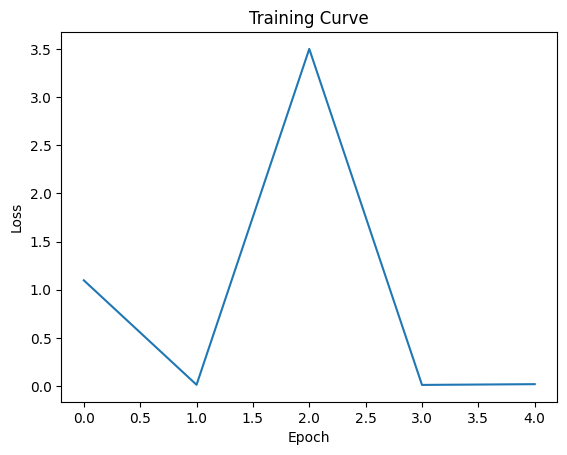

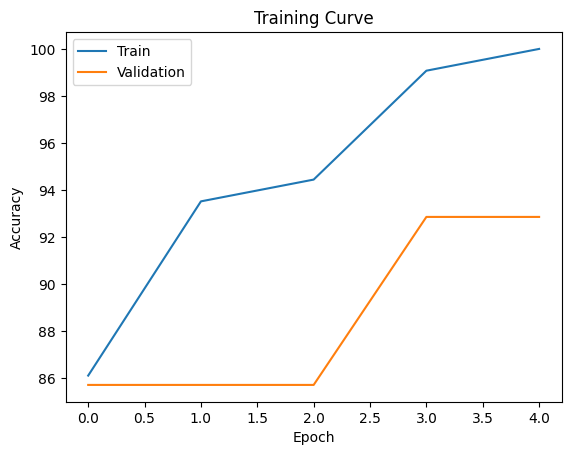

In [ ]:
model = LSTM_Classifier(18, 100, 1, 8)

# Set hyperparameters
batch_size = 1
num_epochs = 5
learning_rate = 0.01

train(model, train_loader, val_loader, batch_size, num_epochs, learning_rate)

In [ ]:
model_path = '/content/model_LSTM_Classifier_bs1_lr0.01_epoch4'
model = LSTM_Classifier(18, 100, 1, 8)

model.load_state_dict(torch.load(model_path))

get_accuracy(model, test_loader)

92.85714285714286

Epoch 1; Loss 1.995439; Train Acc 43.518519; Val Acc 21.428571
Epoch 2; Loss 1.058569; Train Acc 34.259259; Val Acc 35.714286
Epoch 3; Loss 2.554539; Train Acc 44.444444; Val Acc 28.571429
Epoch 4; Loss 0.862059; Train Acc 43.518519; Val Acc 28.571429
Epoch 5; Loss 5.038522; Train Acc 20.370370; Val Acc 35.714286
Epoch 6; Loss 1.764541; Train Acc 32.407407; Val Acc 28.571429
Epoch 7; Loss 1.473667; Train Acc 61.111111; Val Acc 50.000000
Epoch 8; Loss 2.949002; Train Acc 62.037037; Val Acc 57.142857
Epoch 9; Loss 0.134574; Train Acc 91.666667; Val Acc 71.428571
Epoch 10; Loss 0.008694; Train Acc 66.666667; Val Acc 78.571429
Epoch 11; Loss 0.149775; Train Acc 69.444444; Val Acc 85.714286
Epoch 12; Loss 0.142754; Train Acc 86.111111; Val Acc 71.428571
Epoch 13; Loss 0.013567; Train Acc 75.925926; Val Acc 64.285714
Epoch 14; Loss 0.080936; Train Acc 91.666667; Val Acc 92.857143
Epoch 15; Loss 0.041103; Train Acc 91.666667; Val Acc 100.000000
Epoch 16; Loss 0.025505; Train Acc 98.148148; Va

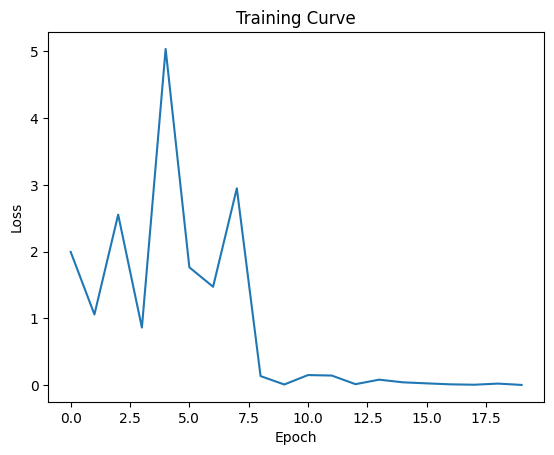

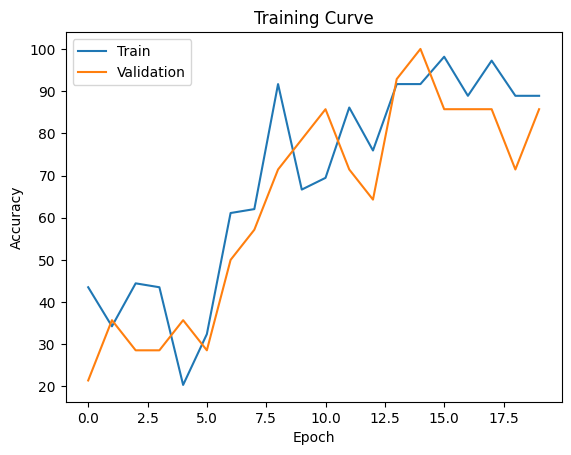

In [ ]:
model = LSTM_Classifier(18, 100, 3, 8)

# Set hyperparameters
batch_size = 1
num_epochs = 20
learning_rate = 0.01

train(model, train_loader, val_loader, batch_size, num_epochs, learning_rate)

In [ ]:
model_path = '/content/model_LSTM_Classifier_bs1_lr0.01_epoch17'
model = LSTM_Classifier(18, 100, 3, 8)

model.load_state_dict(torch.load(model_path))

get_accuracy(model, test_loader)

92.85714285714286

In [ ]:
#model = LSTM_Classifier(6, 100, 1, 2)

# Set hyperparameters
batch_size = 4
num_epochs = 10
learning_rate = 0.001

# Create the DataLoader
data_loader = create_data_loader(data_array, label_array, 1)
get_accuracy(model, test_loader)

100.0

In [ ]:
model = LSTM_Classifier(6, 100, 1, 2)
test_input = data_array[0]
test_input = torch.tensor(test_input, dtype=torch.float32).unsqueeze(0)
print(torch.tensor([len(test_input[0])], dtype=torch.int64))

test_output = model(test_input, torch.tensor([len(test_input[0])], dtype=torch.int64))
print(test_output)

pred = test_output.max(1, keepdim=True)
print(int(test_output.max(1, keepdim=True).indices.item()))


tensor([20])
tensor([[-0.2286, -0.2754]], grad_fn=<AddmmBackward0>)
0
